In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_fontja
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from datetime import datetime, timedelta

/tmp/ipykernel_1365710/2637564029.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 集計

In [2]:
df_dielong = pd.read_parquet("dielong.parquet")

threads_directory = Path("./log/threads")

already_fetched = df_dielong["thread"].tolist()

rows = []
for thread_directory in tqdm(sorted(threads_directory.glob("*"))):
    thread_num = thread_directory.name

    if thread_num in already_fetched:
        continue

    rows_sub = []
    died_flag = False
    for thread_filepath in sorted(thread_directory.glob("*.json")):
        fetched_at = datetime.strptime(thread_filepath.stem, "%Y-%m-%d-%H%M")
        with open(thread_filepath, "r") as f:
            thread = json.load(f)
            dielong = datetime.strptime(thread["dielong"][:-4], "%a, %d %b %Y %H:%M:%S") + timedelta(hours=9)
        rows_sub.append({
            "thread": thread_num,
            "fetched_at": fetched_at,
            "dielong": dielong,
        })
        if thread["old"] == 1:
            died_flag = True
    
    if died_flag:
        rows.extend(rows_sub)


  0%|          | 0/39864 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
df_dielong_new = pd.DataFrame.from_dict(rows)
df_dielong_new = pd.concat((df_dielong, df_dielong_new))
df_dielong_new.to_parquet("dielong.parquet")

## 読み込み

In [3]:
df_dielong = pd.read_parquet("dielong.parquet")
df_dielong["thread"] = df_dielong["thread"].astype("int")

df_threads = df_dielong.groupby("thread")["fetched_at"].agg(["min", "max"]).reset_index()
df_threads.rename(columns={"min": "first", "max": "last"}, inplace=True)
df_threads["lifespan"] = df_threads["last"] - df_threads["first"]

df_dielong = df_dielong.merge(df_threads, on="thread")

# ときどき1970とかの古い日付が帰ってきているので、それを除く(手動でのスレッド削除かも？)
threads_too_far = df_dielong.groupby("thread")["dielong"].apply(lambda x: (x <= "2025-01-01").any())
df_dielong = df_dielong[~df_dielong["thread"].isin(threads_too_far[threads_too_far].index)].copy()

# スレッドが立ってからの相対的な経過分
df_dielong["relative_position"] = df_dielong.groupby("thread").cumcount()
df_dielong["relative_position_reverse"] = df_dielong.groupby("thread").transform("count")["dielong"] - df_dielong.groupby("thread").cumcount() - 1
df_dielong["relative_minute"] = df_dielong["relative_position"] * 10

# 本当のスレッド落ち時間と、データ取得時のスレッド落ちの予測時間との差を計算する
df_dielong["prediction_error"] = (df_dielong["dielong"] - df_dielong["last"]).dt.total_seconds() / 3600  # 時間へ変換

display(len(df_dielong["thread"].unique()))
display(df_dielong)

32977

,thread,fetched_at,dielong,first,last,lifespan,relative_position,relative_position_reverse,relative_minute,prediction_error
0,1286728284,2025-01-09 09:20:00,2025-01-09 21:01:06,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,0,46,0,4.018333
1,1286728284,2025-01-09 09:30:00,2025-01-09 21:08:21,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,1,45,10,4.139167
2,1286728284,2025-01-09 09:40:00,2025-01-09 21:15:24,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,2,44,20,4.256667
3,1286728284,2025-01-09 09:50:00,2025-01-09 21:22:18,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,3,43,30,4.371667
4,1286728284,2025-01-09 10:00:00,2025-01-09 21:29:02,2025-01-09 09:20:00,2025-01-09 17:00:00,0 days 07:40:00,4,42,40,4.483889
...,...,...,...,...,...,...,...,...,...,...
1607546,1301636177,2025-03-08 17:50:00,2025-03-08 19:19:07,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,30,4,300,0.818611
1607547,1301636177,2025-03-08 18:00:00,2025-03-08 19:14:42,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,31,3,310,0.745000
1607548,1301636177,2025-03-08 18:10:00,2025-03-08 19:11:23,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,32,2,320,0.689722
1607549,1301636177,2025-03-08 18:20:00,2025-03-08 19:07:51,2025-03-08 12:50:00,2025-03-08 18:30:00,0 days 05:40:00,33,1,330,0.630833


## スレッド落ちまでの時間

### スレッドの生存時間

10分おきの取得なので歯抜けになっている

<Axes: >

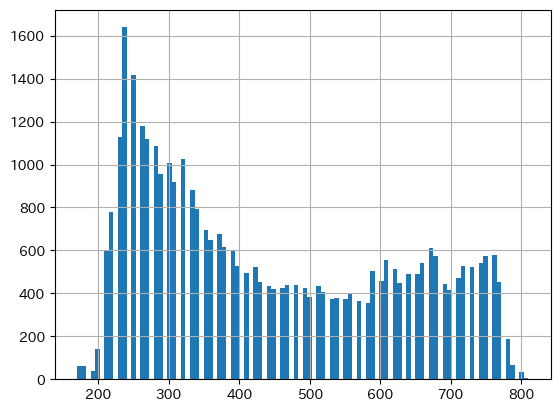

In [4]:
df_threads["lifespan"].apply(lambda x: x.total_seconds() / 60).hist(bins=100)

### どのくらいレス番号が進んだとき、スレッドは落ちるのか

<Axes: >

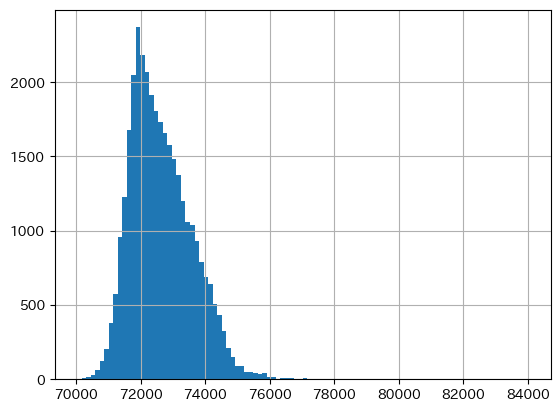

In [5]:
df_minmax = df_threads.merge(df_threads, left_on="last", right_on="first")
df_minmax = df_minmax.drop_duplicates(subset=["thread_x"], keep="first")
df_minmax["lifespan_as_no"] = df_minmax["thread_y"] - df_minmax["thread_x"]
df_minmax["lifespan_as_no"].hist(bins=100)

### スレッド立て時刻ごとの生存時間

/tmp/ipykernel_1365710/2380498388.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_matrix = df_threads.pivot_table(index="lifespan_bin", columns="hour", aggfunc="size", fill_value=0)


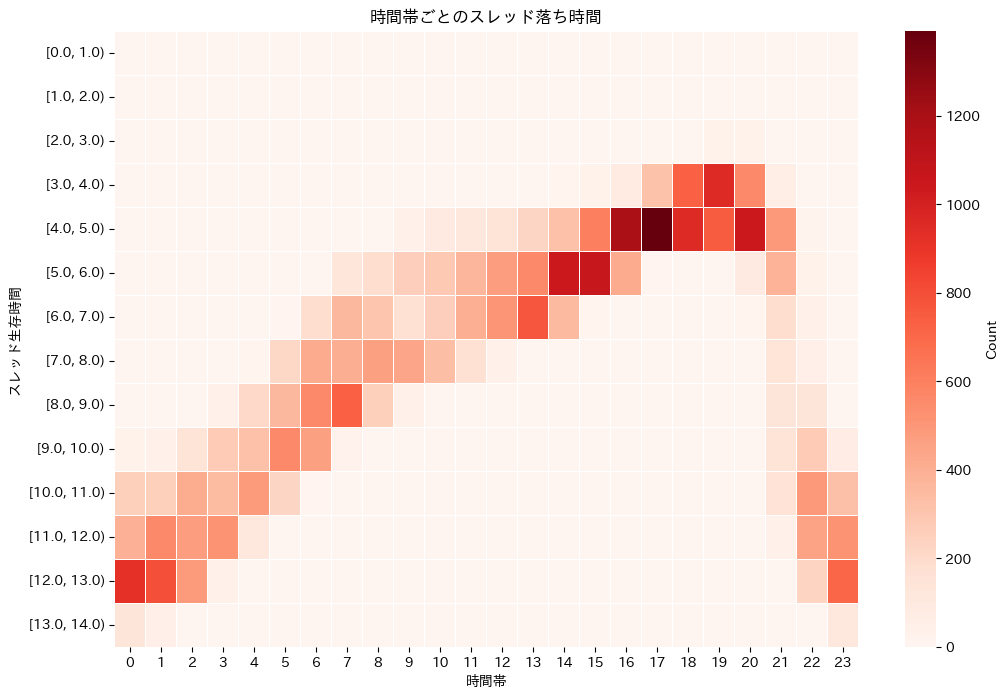

In [6]:
df_threads["hour"] = df_threads["first"].dt.hour

# lifespan を時間単位に変換
df_threads["lifespan_hours"] = df_threads["lifespan"].dt.total_seconds() / 3600

# lifespan をビン分割（1時間ごと）
bin_edges = np.arange(0, df_threads["lifespan_hours"].max() + 1, 1)
df_threads["lifespan_bin"] = pd.cut(df_threads["lifespan_hours"], bins=bin_edges, right=False)

# ピボットテーブルを作成（lifespan_bin × hour）
heatmap_matrix = df_threads.pivot_table(index="lifespan_bin", columns="hour", aggfunc="size", fill_value=0)

# ヒートマップの描画
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_matrix, cmap="Reds", linewidths=0.5, cbar_kws={"label": "Count"})
plt.xlabel("時間帯")
plt.ylabel("スレッド生存時間")
plt.title("時間帯ごとのスレッド落ち時間")
plt.show()

## どのくらい誤差があるのか？

### スレッドが落ちる時刻からの相対的な時間での誤差

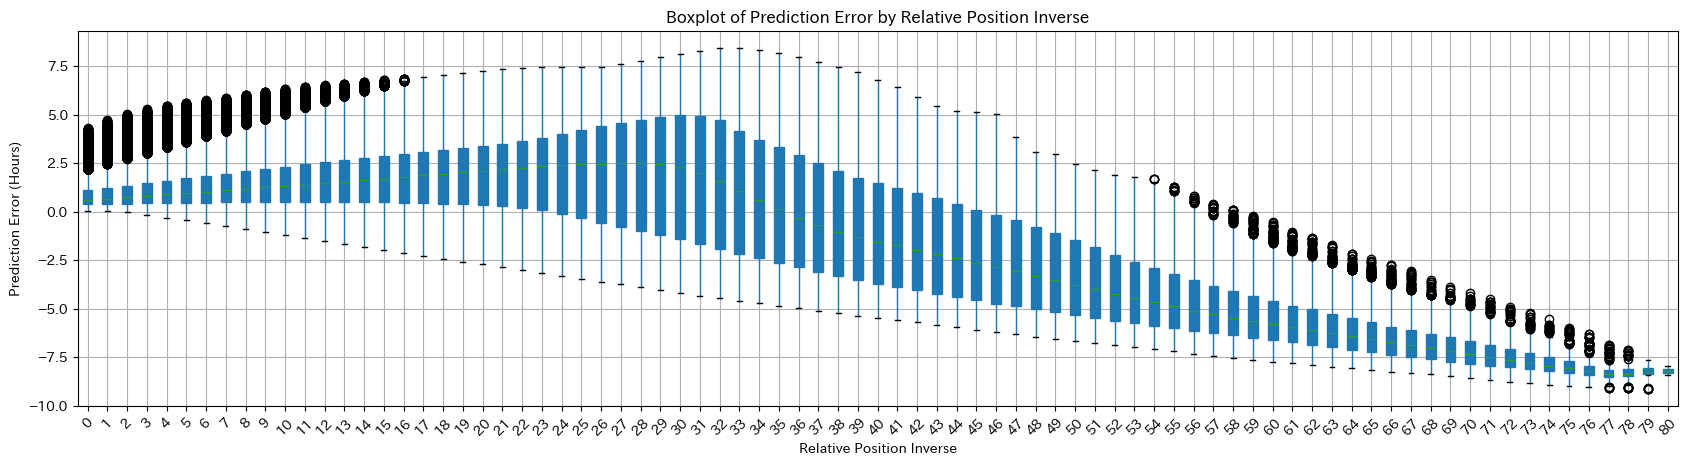

In [7]:
# Boxplot for prediction_error grouped by relative_position
df_dielong.boxplot(column="prediction_error", by="relative_position_reverse", grid=False, showfliers=True, vert=True, patch_artist=True, figsize=(20, 5))

# Customize the plot
plt.title("Boxplot of Prediction Error by Relative Position Inverse")
plt.suptitle("")  # Suppress the automatic GroupBy title
plt.xlabel("Relative Position Inverse")
plt.ylabel("Prediction Error (Hours)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

- 正の誤差は予測よりも早くスレッドが落ちたことを表す
  - 予測時間 - 本当の落ち時間なので

### 時間帯ごとの誤差

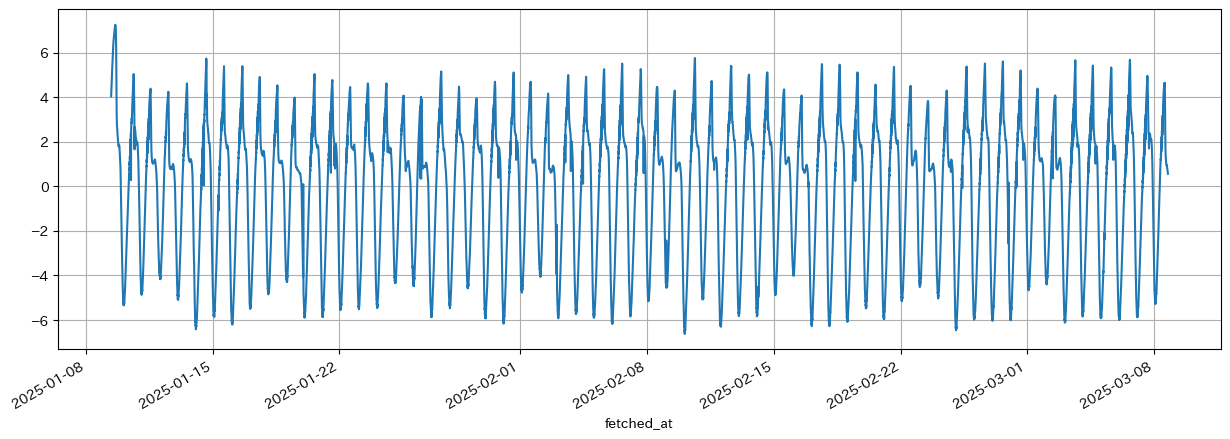

In [8]:
thread_velocity = df_dielong.groupby("fetched_at")["prediction_error"].mean()
thread_velocity.plot(figsize=(15, 5))
plt.grid()
plt.show()

/tmp/ipykernel_1365710/1201567912.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_matrix = df_dielong.pivot_table(index="prediction_error_bin", columns="hour", aggfunc="size", fill_value=0)


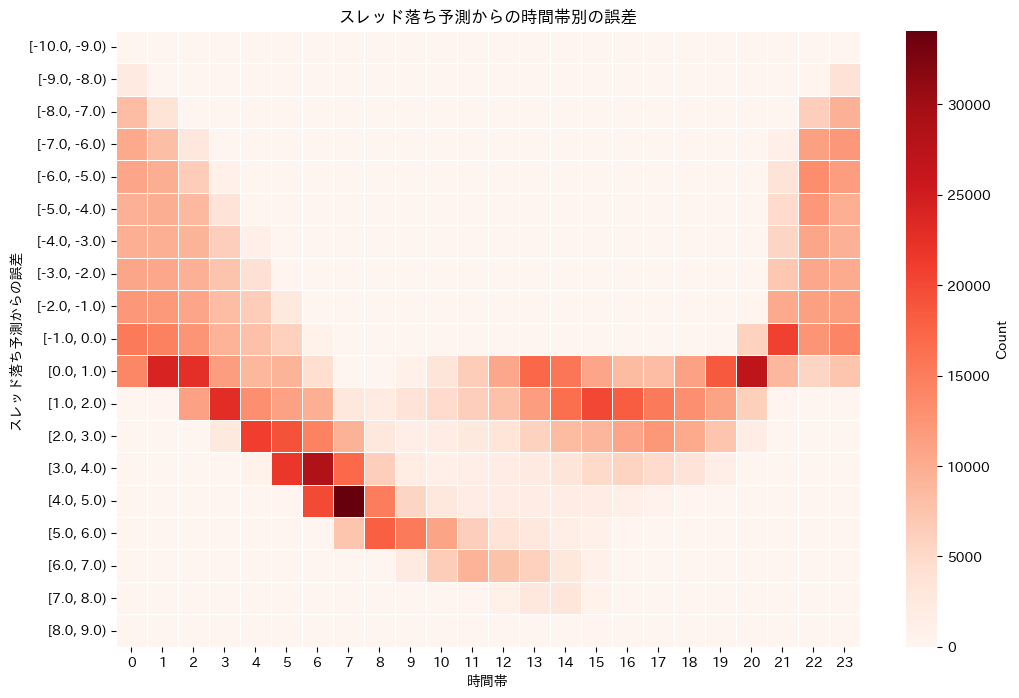

In [9]:
df_dielong["hour"] = df_dielong["first"].dt.hour

bin_edges = np.arange(np.floor(df_dielong["prediction_error"].min()), np.ceil(df_dielong["prediction_error"].max()) + 1, 1)
df_dielong["prediction_error_bin"] = pd.cut(df_dielong["prediction_error"], bins=bin_edges, right=False)

heatmap_matrix = df_dielong.pivot_table(index="prediction_error_bin", columns="hour", aggfunc="size", fill_value=0)

# ヒートマップの描画
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_matrix, cmap="Reds", linewidths=0.5, cbar_kws={"label": "Count"})
plt.xlabel("時間帯")
plt.ylabel("スレッド落ち予測からの誤差")
plt.title("スレッド落ち予測からの時間帯別の誤差")
plt.show()